In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
import ForwardDiff
import DiffResults
using AstrodynamicsBase
using Printf
using JSON
using CSV
using DataFrames
using ColorSchemes
using LaTeXStrings

In [2]:
include("../src/SailorMoon.jl")   # relative path to main file of module
param3b = SailorMoon.dynamics_parameters()
paramMulti = SailorMoon.multi_shoot_parameters(param3b)
gr()
fs = 16


┌ Warning: Replacing docs for `Main.SailorMoon.integrate_rk4 :: Union{Tuple{ODEProblem, Real}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}, Bool}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}, Bool, Bool}}` in module `Main.SailorMoon`
└ @ Base.Docs docs\Docs.jl:240


16

In [3]:
function plot_circle(radius, x, y, n=100)
    circle = zeros(2,n)
    thetas = LinRange(0.0, 2π, n)
    for i = 1:n
        circle[1,i] = radius*cos(thetas[i]) + x
        circle[2,i] = radius*sin(thetas[i]) + y
    end
    return circle
end

plot_circle (generic function with 2 methods)

In [4]:
moon     = plot_circle((1-param3b.mu2)*param3b.lstar, 0.0, 0.0)
earth    = plot_circle(param3b.mu2*param3b.lstar, 0.0, 0.0)
earth_ub = plot_circle(param3b.mu2*param3b.lstar+6375,0.0, 0.0)
earth_lb = plot_circle(param3b.mu2*param3b.lstar-6375, 0.0, 0.0)
moon_soi_outer = plot_circle((1-param3b.mu2)*param3b.lstar+66000, 0.0, 0.0);

In [5]:
function interpolatecolor(cs,value, vmin, vmax)
    cs = cgrad(cs)
    color = cs[(value - vmin) / (vmax - vmin)]
    return color
end

interpolatecolor (generic function with 1 method)

In [6]:
### PARAMETERS ###################################
# csv file to load the initial solution
filename = "data/output_0327_2.csv"
# dv_dir function corresponding to the csv file 
dir_func = SailorMoon.dv_EMrotdir_sb1frame 

n_arc = 5

cs = :lightrainbow 
##################################################

if dir_func == SailorMoon.dv_no_thrust
    τ_ig = 0.0
else 
    τ_ig = 1.0
end

# load initial guess
df = DataFrame(CSV.File(filename));

arcs_color = Dict(
    "xlr_bck_arc" => :blue, 
    "xlr_fwd_arc" => :blue,
    "mid_bck_arc" => :blue, 
    "mid_fwd_arc" => :blue, 
    "lpo_arc" => :blue
)


pcart = plot(
    size=(700,500), frame_style=:box, aspect_ratio=:equal, grid=0.4, legend=false, 
    xlabel=L"x, \times10^6\textrm{km}", ylabel=L"y, \times10^6\textrm{km}",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);

In [9]:

tofs= [row[1] for row in eachrow( df ) ] 
tof_max = maximum(tofs)
tof_min = minimum(tofs)

tof_max_days = tof_max * param3b.tstar / (24*60*60)
tof_min_days = tof_min * param3b.tstar / (24*60*60)

colors = [interpolatecolor(cs, row[1], tof_min, tof_max) for row in eachrow(df)]

for (i, row) in enumerate( eachrow( df ) ) 
    
    x = collect(values(row[3:end]))
    color = colors[i]
    res, sol_param_list, sols_ballistic, tofs = SailorMoon.multishoot_trajectory2(x, dir_func, paramMulti, true, false)
        
    # ballistic legs
    for sol_ballistic in sols_ballistic
        plot!(pcart, (hcat(sol_ballistic.u...)[1,:].- param3b.as) .* param3b.lstar, hcat(sol_ballistic.u...)[2,:].*param3b.lstar, c=color, label=false)
    end
    
    for j = 1:length(sol_param_list)
        sol, _, name = sol_param_list[j]
        plot!(pcart, (sol[1,:] .- param3b.as) .* param3b.lstar , sol[2,:].*param3b.lstar, c=color)
#         plot!(pcart, sol[1,:], sol[2,:], c=color)
    #     scatter!(pcart, [sol[1,1],sol[1,end]], [sol[2,1],sol[2,end]], label=false, c=arcs_color[name], marker=:circle)
    end
    
end


plot!(pcart, earth[1,:], earth[2,:], c=:green, lw=1.0, label="earth")
plot!(pcart, earth_ub[1,:], earth_ub[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart, earth_lb[1,:], earth_lb[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart, moon[1,:], moon[2,:], c=:orange, lw=1.0, label="moon")
plot!(pcart, moon_soi_outer[1,:], moon_soi_outer[2,:], c=:black, lw=1.0, label="moon_soi_outer",
    xaxis=(formatter=x->string(round(x / 10^6; digits=2))),
    yaxis=(formatter=y->string(round(y / 10^6; digits=1))),
)


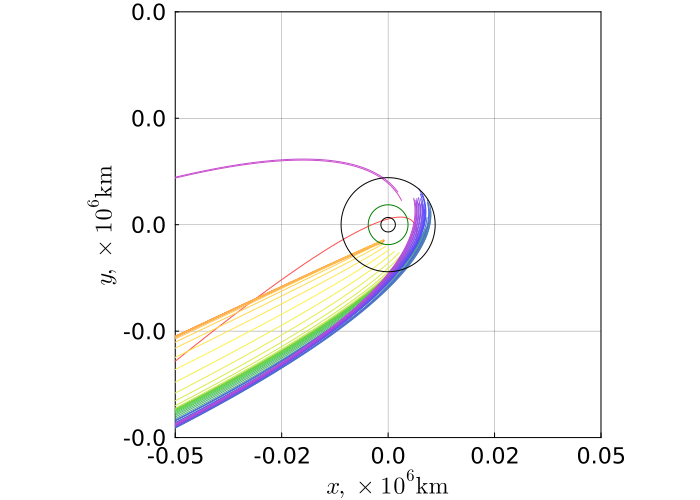

In [8]:
plot!(pcart; xlims=[-0.05, 0.05].*10^6, ylims=[-0.05,0.05].*10^6)


In [60]:
l = @layout [a{0.92w} b{0.03w}]

p2 = heatmap(rand(2,2), clims=(tof_min_days, tof_max_days),
    framestyle=:none, c=cs, cbar=true, lims=(-1,0), colorbar_title="\nToF, days",
    colorbar_titlefontsize=fs,
    colorbar_tickfontsize=fs-1,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1,
    thickness_scaling = 1.6,
    )

plot(pcart, p2, layout=l, size=(900,500), 
#     top_margin=5Plots.mm,
#     right_margin=5Plots.mm,
#     left_margin=5Plots.mm, 
    bottom_margin=5Plots.mm, 
#     title=["No thrust" "Earth-Moon rotating thrust" ""]
    )

savefig("traj_family.png")


GKS: Rectangle definition is invalid in routine SET_VIEWPORT


"C:\\Users\\yujit\\OneDrive\\ドキュメント\\github\\SailorMoon.jl\\tests_yuji\\traj_family.png"